Study of Word2Vec:

- [The Complete Neural Networks Bootcamp: Theory, Applications](https://www.udemy.com/course/the-complete-neural-networks-bootcamp-theory-applications)
- [Word Embeddings Tutorial](https://docs.pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html)
- [Negative Log Likelihood Loss](https://docs.pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss)

## N-Gram

In [23]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.
# Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)
ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]
# Print the first 5, just so you can see what they look like.
print(ngrams[:5])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

[(['forty', 'When'], 'winters'), (['winters', 'forty'], 'shall'), (['shall', 'winters'], 'besiege'), (['besiege', 'shall'], 'thy'), (['thy', 'besiege'], 'brow,')]


In [24]:
losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

# To get the embedding of a particular word, e.g. "beauty"
print(model.embeddings.weight[word_to_ix["beauty"]])

[520.7694346904755, 518.1315999031067, 515.512300491333, 512.9100918769836, 510.3249590396881, 507.75421500205994, 505.1987090110779, 502.6568536758423, 500.1294388771057, 497.6132731437683]
tensor([-0.3743, -2.4118, -1.2774, -0.0639, -0.0941, -2.3154,  0.5570,  0.5059,
        -0.2066,  0.6928], grad_fn=<SelectBackward0>)


## CBOW (Continuous Bag Of Words)

[(['are', 'We', 'to', 'study'], 'about'), (['about', 'are', 'study', 'the'], 'to'), (['to', 'about', 'the', 'idea'], 'study'), (['study', 'to', 'idea', 'of'], 'the'), (['the', 'study', 'of', 'a'], 'idea')]
Epoch 0 - Error: 3.880873519798805
Epoch 10 - Error: 3.6340578342306205
Epoch 20 - Error: 3.3942636539196145
Epoch 30 - Error: 3.1537693327870864
Epoch 40 - Error: 2.9094102773173103
Epoch 50 - Error: 2.6600070986254463
Epoch 60 - Error: 2.4084495408781645
Epoch 70 - Error: 2.1590924602130364
Epoch 80 - Error: 1.9159416926318202
Epoch 90 - Error: 1.6833059166012139
Epoch 100 - Error: 1.4653594087937782
Epoch 110 - Error: 1.2654483369712173
Epoch 120 - Error: 1.085479340419687
Epoch 130 - Error: 0.9265465315045982
Epoch 140 - Error: 0.788424920933
Epoch 150 - Error: 0.6702969045988445
Epoch 160 - Error: 0.5706690083546885
Epoch 170 - Error: 0.4875844528192076
Epoch 180 - Error: 0.4187371052544692
Epoch 190 - Error: 0.36178324667030365
Epoch 200 - Error: 0.31471240263560724
Epoch 210 -

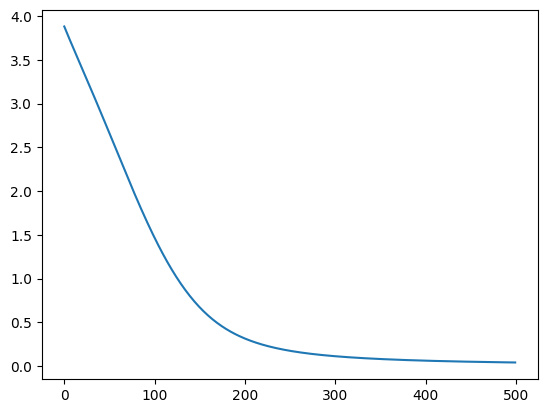

tensor([ 1.4611, -0.9072, -0.3904,  0.1336, -0.4532, -0.7941,  0.1024,  0.8421,
         0.2713,  1.0738], grad_fn=<SelectBackward0>)


In [65]:
import numpy as np
import matplotlib.pyplot as plt

CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EPOCHS = 500
EMBEDDING_DIM = 10
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for word, i in word_to_ix.items()}
data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = (
        [raw_text[i - j - 1] for j in range(CONTEXT_SIZE)]
        + [raw_text[i + j + 1] for j in range(CONTEXT_SIZE)]
    )
    target = raw_text[i]
    data.append((context, target))
print(data[:5])

def make_context_vector(context: tuple, word_to_ix: dict):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

def make_words(idxs: torch.Tensor):
    words = [ix_to_word[i.item()] for i in idxs]
    return words

class CBOW(nn.Module):

    def __init__(self, vocab_size: int, embedding_dim: int, context_size: int):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # the input will be reshaped, must be 2 times because it's 2 before and 2 after
        full_context_size = 2 * context_size
        self.linear1 = nn.Linear(full_context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs: torch.Tensor):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        return F.log_softmax(out, dim=1)

# Create your model and train. Here are some functions to help you make
# the data ready for use by your module.
losses = []

cbow_model = CBOW(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE)
# negative log likelihood loss
loss_func = nn.NLLLoss()
opt = optim.SGD(cbow_model.parameters(), lr=0.001)
for epoch in range(EPOCHS):
    losses_epoch = []
    for context, target in data:
        opt.zero_grad()
        inputs = make_context_vector(context, word_to_ix)
        logs_pred = cbow_model(inputs)
        target_idx = make_context_vector([target], word_to_ix)
        loss = loss_func(logs_pred, target_idx)
        loss.backward()
        opt.step()
        losses_epoch.append(loss.item())
    mean_error = np.mean(losses_epoch)
    losses.append(mean_error)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Error: {mean_error}")

x = np.arange(len(losses))
plt.plot(x, losses, '-')
plt.show()

# To get the embedding of a particular word, e.g. "beauty"
print(cbow_model.embeddings.weight[word_to_ix["processes"]])

In [66]:
test_pred = make_context_vector(data[0][0], word_to_ix)  # example
make_words(test_pred)

['are', 'We', 'to', 'study']

In [76]:
def predict(text):
    with torch.no_grad():
        phrase = text.split(" ")
        inputs = make_context_vector(phrase, word_to_ix)
        logs_prod = cbow_model(inputs)
        pred_idx = logs_prod.argmax(axis=1)
        return make_words(pred_idx)

print(predict("People create to direct"))  # programs
print(predict("processes are beings that"))  # should be abstract, but isn't

['programs']
['beings']
